# 1. Downloading the images
---


Our task is to generate images of dogs, so first we are going to need a lot of dog pictures.

We have chosen to use images from the Google Open Image Dataset V5.

This dataset contains 6 million images of a variety of different objects. Since this dataset is too large for us to download it all, and we only need images of dogs, we are going to filter it first, then download only what we need.





In [0]:
!pip install awscli
# Download dataset metadata:
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv 
!wget https://datasets.figure-eight.com/figure_eight_datasets/open-images/test-images.csv
# Parsing the dataset download links:
import pandas as pd
descriptions = pd.read_csv(r"class-descriptions-boxable.csv", sep=",", index_col=None, header=None)
dog_id = descriptions.loc[descriptions[1] == 'Dog'].iloc[0][0] # Get only the images that has a dog on it.
annotations = pd.read_csv(r"test-annotations-bbox.csv", sep=",", index_col=None)
dog_pictures = annotations.loc[annotations['LabelName'] == dog_id]
image_links = pd.read_csv(r"test-images.csv", sep=",", index_col=None)

In [0]:
# Downloading the images: (This takes a looong time..)
!rmdir -rf images
!mkdir images
import requests
import sys
lastpicture = ""
for id, picture in enumerate(dog_pictures["ImageID"]):
    if picture != lastpicture: 
        filename = "images/" + str(id+1) + ".jpg"
        url = image_links.loc[image_links['image_name'] == picture+".jpg"].iloc[0][1]    
        with open(filename, 'wb') as f:
            f.write(requests.get(url).content)
    lastpicture = picture

The downloaded images are of different sizes, so we need to resize them first. We will be using 64x64 images


In [0]:
# Resizing the downloaded images
from PIL import Image
import os, sys
!rm -r resized
!mkdir resized
path = "/content/resized"
outpath = "/content/resized0/"
dirs = os.listdir( path )

def resize():
    i = 0
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            imResize = im.resize((64,64), Image.ANTIALIAS)
            imResize.save(outpath + str(i) + '.jpg', 'JPEG', quality=90)
            i+=1
resize()

The above process takes a long time, so we've prepared a ZIP file so we don't have to repeat the above steps.

This file contains 4835 64x64 different images of dogs

In [1]:
!rm -f resized64.zip
!wget https://www.dropbox.com/s/rgetz6d16m1wvap/resized64.zip #64x64
!rm -rf images
!unzip resized64.zip

--2019-11-17 23:54:27--  https://www.dropbox.com/s/rgetz6d16m1wvap/resized64.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rgetz6d16m1wvap/resized64.zip [following]
--2019-11-17 23:54:27--  https://www.dropbox.com/s/raw/rgetz6d16m1wvap/resized64.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc38b3d31d9e53edb99429011757.dl.dropboxusercontent.com/cd/0/inline/AuOcTorhP-WOesVK4Pqb2BaujVGNT02wBylFnsOdVlI9Gi6bIoZPiNmGMn6NA-GWkjUBF6_IsrhtWLsc_qQSyPUidc0k9sp-rA2ajxhIwqFovMjpNz3D_jljQcMC4McpLWY/file# [following]
--2019-11-17 23:54:28--  https://uc38b3d31d9e53edb99429011757.dl.dropboxusercontent.com/cd/0/inline/AuOcTorhP-WOesVK4Pqb2BaujVGNT02wBylFnsOdVlI9Gi6bIoZPiNmGMn6NA-GWkjUBF6_IsrhtWLsc_qQSyPUidc0k9sp-rA2ajxhIwqFo

# 2. Training data visualization

---


Let us take a look at the images:

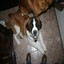

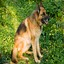

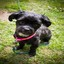

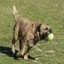

In [2]:
from IPython.display import Image
from IPython.display import display
display(Image('images/1.jpg'))
display(Image('images/2.jpg'))
display(Image('images/123.jpg'))
display(Image('images/321.jpg'))

# 3. Preparing the data

---

Now we need to transform the image to a form we can feed into a neural network


In [3]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os
x_list = []
for filename in os.listdir("images/"):
  # Loading each image into an array
  img = np.asarray(image.load_img("images/"+filename))
  x_list.append(img)
x_train = np.asarray(x_list)

# Transforming data values from (0, 255) to (-1, 1):
x_train = x_train / 127.5 - 1

In [4]:
print(x_train.shape) # The training dataset contains 4835 images with the size of 64x64 each having 3 color channels.

(4835, 64, 64, 3)


In [0]:
# We now have a dataset that can be used to train a neural network.

# 4. Constructing a network


---

For now we are using a network from this github repository:

https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [6]:
!pip install SpectralNormalizationKeras

ERROR: Could not find a version that satisfies the requirement SpectralNormalizationKeras (from versions: none)
ERROR: No matching distribution found for SpectralNormalizationKeras


In [7]:
# Imports:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization,Conv2D,MaxPooling2D,Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np


Using TensorFlow backend.


In [0]:
# Defining constants:
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
BN_MIMENTUM = 0.1
BN_EPSILON  = 0.00002

batch_size = 16

class GAN():
  def __init__(self):
    self.img_rows = 64
    self.img_cols = 64
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)    
    self.latent_dim = 100
    optimizer = Adam(0.0001, 0.5)    
    
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
    
    # Initializing generator
    self.generator = self.build_generator()
       
    z = Input(shape=(self.latent_dim,))
    # Creating image from latent dimensions
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy', optimizer=optimizer)
    
    # Building the discriminator network:
    # Its task is to tell the real and fake images apart
  def build_discriminator(self):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation=LeakyReLU(), input_shape = self.img_shape)) 
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, kernel_size=3, strides=3, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid')) 

    model.summary()
    
    img = Input(shape=self.img_shape)
    
    validity = model(img)
    
    return Model(img, validity)
  
  # Building the generator network
  # This network generates images based of data from the latent dimensions
  def build_generator(self):
  
    model = Sequential()
    model.add(Dense(8*8*512, kernel_initializer='glorot_uniform' , input_dim = self.latent_dim))
    model.add(Reshape((8,8,512)))
    model.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(512, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform'))   
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(256, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform'))   
    model.add(Conv2D(256, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(256, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
   
    model.add(Conv2D(128, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(128, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    
    model.add(Conv2D(128, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(32, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    
    model.add(Conv2D(32, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
   
    model.add(Conv2D(32, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(32, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(Conv2D(32, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    
    model.add(Conv2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh'))
    
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)   


In [9]:
# Creating the GAN network
gan = GAN()
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 31, 256)       590080    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 256)       590080    
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)         

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))










Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       4194816   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 512)       4194816   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 25

# 5. Training the network

---




/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


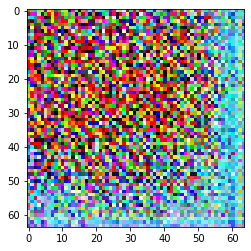

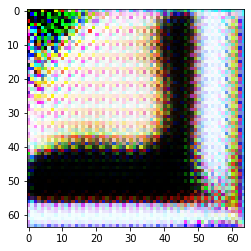

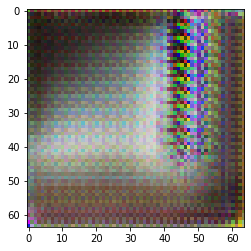

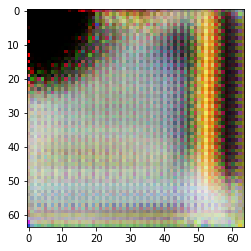

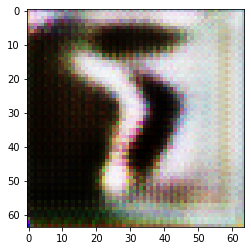

In [10]:
# training networks:
import matplotlib.pyplot as plt
for step in range(500):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]
  # Creating a batch of images
  noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)    
  g_loss = gan.combined.train_on_batch(noise, valid)
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
  # Drawing a generated image every 100th step
  if step % 100 == 0:
    noise = np.random.normal(0, 1, (1, gan.latent_dim))
    gen_imgs = gan.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    imgplot = plt.imshow(gen_imgs[0])
    plt.show()
    